In [190]:
import torch
import numpy
import pandas as pd
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [150]:
# Define Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 1
batch_size = 1
learning_rate = 0.001

### MNIST dataset 

In [151]:
train_dataset = torchvision.datasets.MNIST(root='..//set', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

In [152]:
test_dataset = torchvision.datasets.MNIST(root='..///set', 
                                          train=False, 
                                          transform=transforms.ToTensor())

In [153]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Fully connected neural network

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

### Loss and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

### Train the model

In [ ]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

### Test the model

In [ ]:
# In the test phase, don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'cutom_arch.ckpt')

### Confusion Matrix

In [ ]:
#testset
x_test,y_test = next(iter(test_loader))
x_test = images.reshape(-1, 28*28).to(device)
y_pred = model(x_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels, numpy.argmax(y_pred, axis=1))

In [ ]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.reshape(-1,28*28).to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.int(), p.int()] += 1

In [ ]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

### Building confusion matrix

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.reshape(-1,28*28).to(device)
        labels = labels.to(device)

        preds = model(images).to(device)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [ ]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_dataset, batch_size =10000)
    train_preds = get_all_preds(model, prediction_loader).to(device)

In [ ]:
train_preds.shape

In [ ]:
train_preds.grad_fn

In [ ]:
train_preds.grad

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
preds_correct = get_num_correct(train_preds, test_dataset.targets.to(device) )
print('total correct', preds_correct)
print('accuracy', preds_correct / len(test_dataset))

In [ ]:
train_preds.is_cuda

In [ ]:
# test_dataset.targets.to(device)

In [158]:
stacked = torch.stack((test_dataset.targets.to(device), train_preds.argmax(dim=1)), dim=1)

In [160]:
stacked[9].tolist()

[5, 5]

In [162]:
cmt = torch.zeros(10,10, dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [163]:
for p in stacked:
    j,k = p.tolist()
    cmt[tl,pl] = cmt[tl, pl] + 1

In [164]:
cmt

tensor([[ 929,    1,    4,    0,    0,    8,   32,    1,    5,    0],
        [   0, 1126,    2,    2,    0,    0,    3,    0,    2,    0],
        [   5,   23,  915,   19,   12,    1,   14,    7,   35,    1],
        [   1,    8,   19,  881,    0,   44,    2,   10,   44,    1],
        [   0,    3,    2,    2,  911,    0,   24,    2,   11,   27],
        [   5,    2,    6,   13,    5,  829,   18,    4,    8,    2],
        [   5,    3,    1,    0,    3,   10,  933,    1,    2,    0],
        [   4,   24,   31,   12,    5,    0,    0,  918,    9,   25],
        [   5,   21,    4,   12,    4,   27,   22,    4,  874,    1],
        [   5,    9,    4,   28,   33,   23,    4,   19,   61,  823]])

In [165]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [180]:
lb = test_dataset.targets.detach().cpu().numpy()

In [181]:
rp = train_preds.argmax(dim=1).detach().cpu().numpy()

In [182]:
cm = confusion_matrix(lb, rp)

In [192]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
numpy.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [1, 4]

Confusion matrix, without normalization
[[ 929    1    4    0    0    8   32    1    5    0]
 [   0 1126    2    2    0    0    3    0    2    0]
 [   5   23  915   19   12    1   14    7   35    1]
 [   1    8   19  881    0   44    2   10   44    1]
 [   0    3    2    2  911    0   24    2   11   27]
 [   5    2    6   13    5  829   18    4    8    2]
 [   5    3    1    0    3   10  933    1    2    0]
 [   4   24   31   12    5    0    0  918    9   25]
 [   5   21    4   12    4   27   22    4  874    1]
 [   5    9    4   28   33   23    4   19   61  823]]


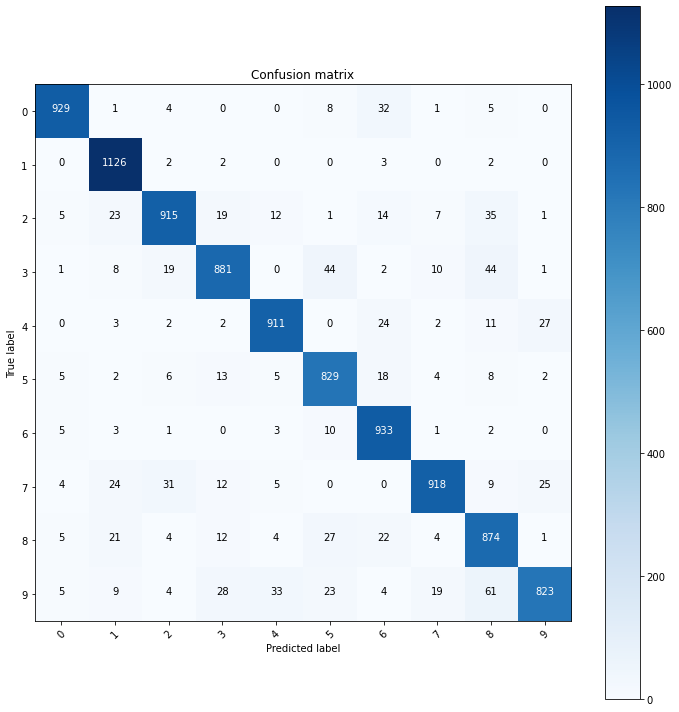

In [191]:
names = ('0','1','2', '3', '4','5', '6', '7', '8', '9')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)